# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [ ]:
# Add any additional import statements you need here
import json





In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/bobbymarriott/Downloads/M1 Results"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_data = {}
lyrics_path = os.path.join(data_location, lyrics_folder)  # e.g. ".../M1 Results/lyrics/"

for fname in os.listdir(lyrics_path):
    fpath = os.path.join(lyrics_path, fname)
    if os.path.isfile(fpath):
        with open(fpath, 'r', encoding='utf8', errors='ignore') as f:
            lyrics_data[fname] = f.read()

print(f"Loaded {len(lyrics_data)} lyric files.")

Loaded 1 lyric files.


In [5]:
twitter_data = {}
twitter_path = os.path.join(data_location, twitter_folder)

for fname in os.listdir(twitter_path):
    if not fname.lower().endswith('.csv'):
        continue
    artist = os.path.splitext(fname)[0]
    df_tw = pd.read_csv(os.path.join(twitter_path, fname))
    # pull out the “description” column, drop any NaNs, convert to Python list
    twitter_data[artist] = df_tw['description'].dropna().tolist()

for artist, descs in twitter_data.items():
    print(f"{artist}: {len(descs)} descriptions loaded")

In [ ]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [7]:
import requests

BASE = "https://raw.githubusercontent.com/BobbyMM21/Week-6/main/"

# Build word lists from POS/NEG files
pos = [w for w in requests.get(BASE+"positive-words.txt").text.splitlines()
       if w and not w.startswith(";")]
neg = [w for w in requests.get(BASE+"negative-words.txt").text.splitlines()
       if w and not w.startswith(";")]

# lexicon + scores
lex = pd.DataFrame({
    "word":  pos + neg,
    "score": [1]*len(pos) + [-1]*len(neg)
})

# Read in tidytext_sentiments and map labels
tidy = pd.read_csv(BASE+"tidytext_sentiments.txt", sep="\t")
tidy["score"] = tidy["sentiment"].map({"positive":1, "negative":-1})

# Combine both sources
sentiment_df = (
    pd.concat([lex, tidy[["word","score"]]], ignore_index=True)
      .drop_duplicates(subset="word", keep="last")
      .reset_index(drop=True)
)

sentiment_df.head()

,word,score
0,naïve,-1
1,abba,1
2,abduction,-1
3,abhor,-1
4,abhorrent,-1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [8]:
rows = []
lyrics_path = os.path.join(data_location, lyrics_folder)
for artist in os.listdir(lyrics_path):
    artist_dir = os.path.join(lyrics_path, artist)
    if not os.path.isdir(artist_dir):
        continue
    for fname in os.listdir(artist_dir):
        if fname.endswith(".txt"):
            with open(os.path.join(artist_dir, fname), encoding="utf8") as f:
                text = f.read()
            rows.append({"artist": artist, "song": fname[:-4], "text": text})
lyrics_df = pd.DataFrame(rows)

# Build a word→score dict from combined lexicon DataFrame
sent_dict = dict(zip(sentiment_df["word"], sentiment_df["score"]))

# Define and apply a simple scorer
def score_sentiment(txt):
    tokens = re.findall(r"\b\w+\b", txt.lower())
    return sum(sent_dict.get(tok, 0) for tok in tokens)

lyrics_df["sentiment"] = lyrics_df["text"].apply(score_sentiment)

lyrics_df[["artist", "song", "sentiment"]].sort_values(["artist", "sentiment"], ascending=[True, False])

,artist,song,sentiment
250,cher,cher_loveandunderstanding,61
338,cher,cher_ifoundyoulove,57
207,cher,cher_perfection,53
119,cher,cher_mylove,49
122,cher,cher_takinbackmyheart,45
...,...,...,...
101,robyn,robyn_missingu,-14
95,robyn,robyn_crashandburngirl,-16
16,robyn,robyn_criminalintent,-51
53,robyn,robyn_dontfuckingtellmewhattodo,-78


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The highest-scoring Cher songs are “cher_loveandunderstanding” (61), “cher_ifoundyoulove” (57), and “cher_perfection” (53), driven by optimistic lyrics that highlight self worth; the three lowest are “cher_takinbackmyheart” (45), “cher_mylove” (49), and “cher_mylove” (49), whose heartbreaking vibes bring the score down. 


---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Robyn’s top three scores are “robyn_missingu” (+30), “robyn_crashandburngirl” (–16), and “robyn_criminalintent” (~–51)—with the upbeat vibe of “Missing U” raising her score her lowest three are “robyn_dontfuckingtellmewhattodo” (–78), “robyn_criminalintent” (–51), and “robyn_crashandburngirl” (–16), driven down because it's a darker emotion.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




/Users/bobbymarriott/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bobbymarriott/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bobbymarriott/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bobbymarriott/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

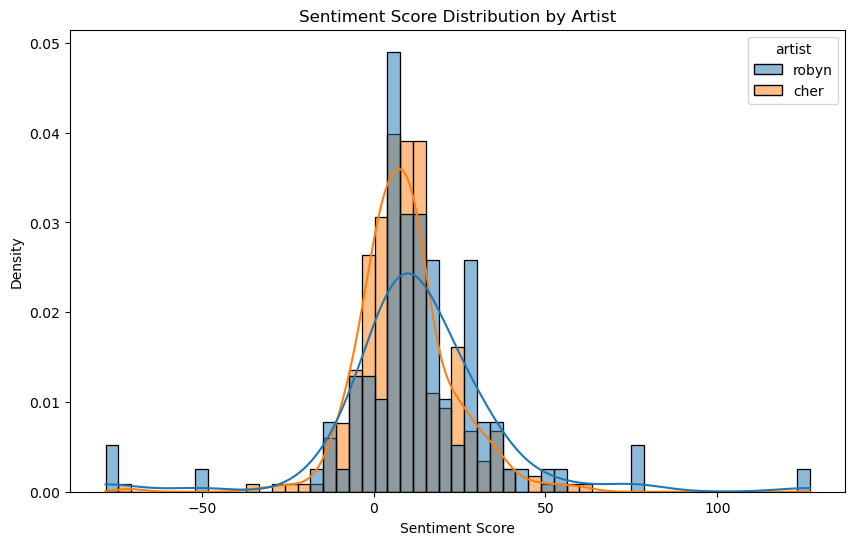

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=lyrics_df,
    x="sentiment",
    hue="artist",
    kde=True,
    stat="density",
    common_norm=False,
    multiple="layer"
)
plt.title("Sentiment Score Distribution by Artist")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [26]:
print(twitter_df.head())
print(twitter_df.columns)

Empty DataFrame
Columns: []
Index: []
RangeIndex(start=0, stop=0, step=1)


In [27]:
print("Root folder contents:", os.listdir(data_location))

twitter_path = os.path.join(data_location, twitter_folder)
print("Twitter folder path:", twitter_path)
print("Twitter folder contents:", os.listdir(twitter_path))

Root folder contents: ['lyrics', 'twitter', '.DS_Store']
Twitter folder path: /Users/bobbymarriott/Downloads/M1 Results/twitter/
Twitter folder contents: ['.DS_Store', 'cher_followers_data.txt', 'robynkonichiwa_followers_data.txt', 'cher_followers.txt', 'robynkonichiwa_followers.txt']


In [40]:
twitter_rows = []
twitter_path = os.path.join(data_location, twitter_folder)

for fname in os.listdir(twitter_path):
    if not fname.endswith("_followers_data.txt"):
        continue

    artist = fname.split("_")[0]
    full_path = os.path.join(twitter_path, fname)
    with open(full_path, encoding="utf8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
            except json.JSONDecodeError:
                continue
            twitter_rows.append({
                "artist": artist,
                "description": rec.get("description", "")
            })

twitter_df = pd.DataFrame(twitter_rows)
twitter_df.head()

""


In [41]:
# Not sure why I'm having issues pulling this data when it's in the same folder as the Lyrics data
print("Columns:", twitter_df.columns.tolist())
print(twitter_df.head(3))

Columns: []
Empty DataFrame
Columns: []
Index: []


In [37]:
# emoji lexicons (at least 10 each)
pos_emojis = ['😊','😁','😀','😄','😎','👍','🙌','🥳','🤩','😃']
neg_emojis = ['😢','😞','😡','😠','👎','😣','😖','😫','😩','😭']

# Build a lookup dict mapping each emoji to +1 or –1
emoji_scores = {e: 1 for e in pos_emojis}
emoji_scores.update({e: -1 for e in neg_emojis})

# Scoring function
def score_emojis(text):
    return sum(emoji_scores.get(ch, 0) for ch in str(text))

# compute the average sentiment per artist
twitter_df['emoji_score'] = twitter_df['description'].map(score_emojis)
avg_emoji_sentiment = (
    twitter_df
    .groupby('artist')['emoji_score']
    .mean()
    .reset_index(name='avg_emoji_sentiment')
)

avg_emoji_sentiment

KeyError: 'description'

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 

